In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import BFast
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'font.size': 13})
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
BoxSize = 1000.
kF = 2*np.pi/BoxSize
grid = 256

In [3]:
df = np.load(f"df_m_256_PCS_z=0.npy")

In [4]:
help(BFast.Bk_fast)

Help on function Bk_fast in module BFast.BFast:

Bk_fast(delta, BoxSize, fc, dk, Nbins, triangle_type, MAS, verbose=False)



In [5]:
%time Bks_fast = BFast.Bk_fast(df,BoxSize,3.,3.,27,'All','PCS',verbose=True)

No counts file found, computing this first!
Considering 2276 Triangle Configurations (All)


100%|██████████| 2276/2276 [00:02<00:00, 1119.20it/s]


Saved Triangle Counts to BFast_BkCounts_LBox1000_Grid256_Binning3kF_fc3_NBins27_TriangleTypeAll.npy


100%|██████████| 2276/2276 [00:01<00:00, 1393.55it/s]

CPU times: user 5.11 s, sys: 877 ms, total: 5.99 s
Wall time: 6.15 s


In [6]:
%time Bks = BFast.Bk(df,BoxSize,3.,3.,27,'All','PCS',verbose=True)

Loading Counts from BFast_BkCounts_LBox1000_Grid256_Binning3kF_fc3_NBins27_TriangleTypeAll.npy
Considering 2276 Triangle Configurations (All)


100%|██████████| 2276/2276 [00:12<00:00, 188.22it/s]


CPU times: user 9.26 s, sys: 3.05 s, total: 12.3 s
Wall time: 12.3 s


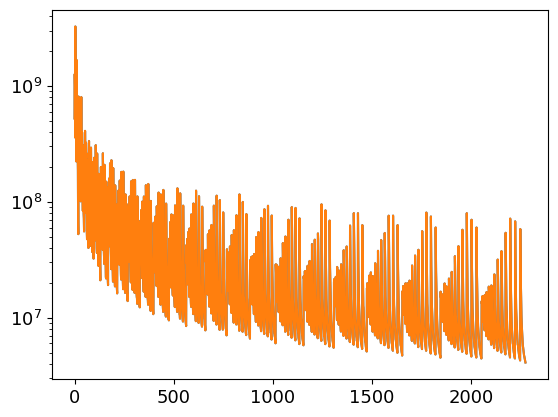

In [7]:
plt.semilogy(Bks_fast[:,-2])
plt.semilogy(Bks[:,-2])

In [8]:
Bks_fast[:,-2] - Bks[:,-2]

array([0., 0., 0., ..., 0., 0., 0.])